<h1>Natural Language Processing with Disaster Tweets Kaggle Competition

<h3><font color="gray">Step 1 "Brief description of the problem and data (5 pts)"</font>

The purpose of this competition is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. The data are from [Kaggle.com]("https://www.kaggle.com/competitions/nlp-getting-started/overview") and comprised of 10,876 tweets, broken into train and test sets.

The analysis that follows borrows code directly from [KerasNLP starter notebook Disaster Tweets 76c6b3]("https://www.kaggle.com/code/stevenhobbs74/kerasnlp-starter-notebook-disaster-tweets-76c6b3/edit"). Due to challenges running certain tensorflow and keras modules on my apple computer with an M1 chip, the analysis below was run on Google Colab.

<h3><font color="gray">Step 2 "Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)"</font>

The train set is a CSV file with 7613 observations and 5 columns that include id, keyword, location, text, and target. The string-valued text column contains the tweets, which range from 7 to 157 characters in length and have a mean of 101 characters. The target column

The test set is a CSV file with 3263 tweets with the same columns as the train set, minus a target. The test set tweets range in length from 5 to 151 characters with a mean of 102 characters.

The data have no missing values and require no cleaning.

<h4><font color="gray">Loading libraries<font><h4>

In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.0 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
from tensorflow import keras
import keras_nlp
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.15.0
KerasNLP version: 0.6.4


<h4><font color="gray">Load and inspect data<font><h4>

In [6]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


<h4><font color="gray">Tweet length in train and test data<font><h4>

In [7]:
df_train["length"] = df_train["text"].apply(len)
df_test["length"] = df_test["text"].apply(len)

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


<h4><font color="gray">Visualize the data<font><h4>

In [8]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<h3><font color='gray'>Step 3: "Model Architecture (25 points)"<font>

I used the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP. DistilBERT is a 40% smaller and 60% faster version of BERT, Bidirectional, Encoder Representations from Transformers. DistilBERT retains 97% of the language understanding ability of BERT and is ideal for transfer learning. Being bidirectional language models, BERT and DistilBERT are able to process each word in the full context of the text that came before and after the word.

DistilBERT includes a tokenizer preprocessor called DistilBertTokenize followed by a 7-layer transformer architecture. The first two layers are input layers and include padding to accommodate tweets of various lengths.The next two layers are processing layers with 768 output features each. The three remaining layers are dense, dropout and a logit binary classifier.

Unlike models that use RNNs, GRUs, or LSTMs, DistilBERT employs attention mechanisms, particularly multi-head self-attention, to process sequences of input data. This design allows it to focus on different parts of the input sequence and understand context more effectively. DistilBERT also includes layer normalization and a residual connection around each sub-block (self-attention and feed-forward network), following the standard architecture of transformer models.

The DistilBERT pretrained model is fine-tuned on the Tweet training set before being used to predict on the test set. As shown below, I split the training data into 80% train and 20% validation sets to train parameters and avoid overfitting. Using a batch size of 32, I fine-tune the model for 2 epochs and use TensorFlow's AUTOTUNE module to adjust hyperparameters.

In [9]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [10]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [11]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

265570304/265570304 [==============================] - 8s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 6335s 33s/step - loss: 0.4895 - accuracy: 0.7727 - val_loss: 0.3912 - val_accuracy: 0.8464
Epoch 2/2
191/191 [==============================] - 6206s 33s/step - loss: 0.3684 - accuracy: 0.8499 - val_loss: 0.3814 - val_accuracy: 0.8450


<h3><font color='gray'>Step 4. Results and Analysis (35 pts)<font><h3>

As the output below reveals, the DistilBERT model fine-tuned on the train dataset performed will, receiving an F1 score of .87. The DistilBERT model performed slightly less well on the validation data with an F1 Score of .81. The lower validation score suggests the model may be slightly overfitting the data. However, the F1 scores are close enough to be different due to random variation.

In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

<h4><font color='gray'>Train predictions

191/191 [==============================] - 1866s 10s/step


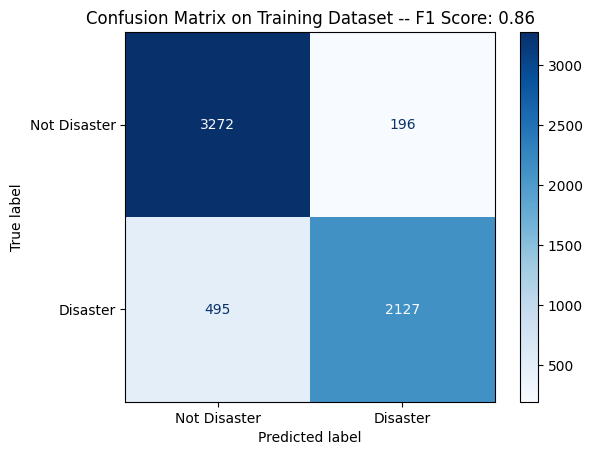

In [14]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

<h4><font color='gray'>Validation predictions

48/48 [==============================] - 475s 10s/step


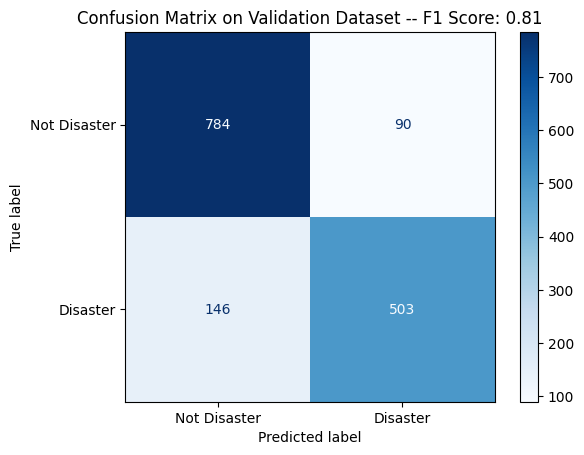

In [15]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

<h4><font color='gray'>Test data prediction & Kaggle submission<font><h4>

In [16]:
# Predict on the test data
y_pred_test = classifier.predict(X_test)

102/102 [==============================] - 1003s 10s/step


In [24]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

sample_submission['target'] = np.argmax(y_pred_test, axis = 1)
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [25]:
sample_submission.to_csv('predictions.csv', index = False)

<h4><font color='gray'>Discussion<font><h4>

As shown in the screenshot below, the DistilBERT model fine-tuned on the training dataset performed well on the unseen Kaggle submission data, receiving an F1 score of .84. This is slightly better than the F1 score on the validation data, .81, suggesting the model is not strongly overfitting, which would be indicated by a lower test F1 score. Overall, I am pleased with the model's performance.

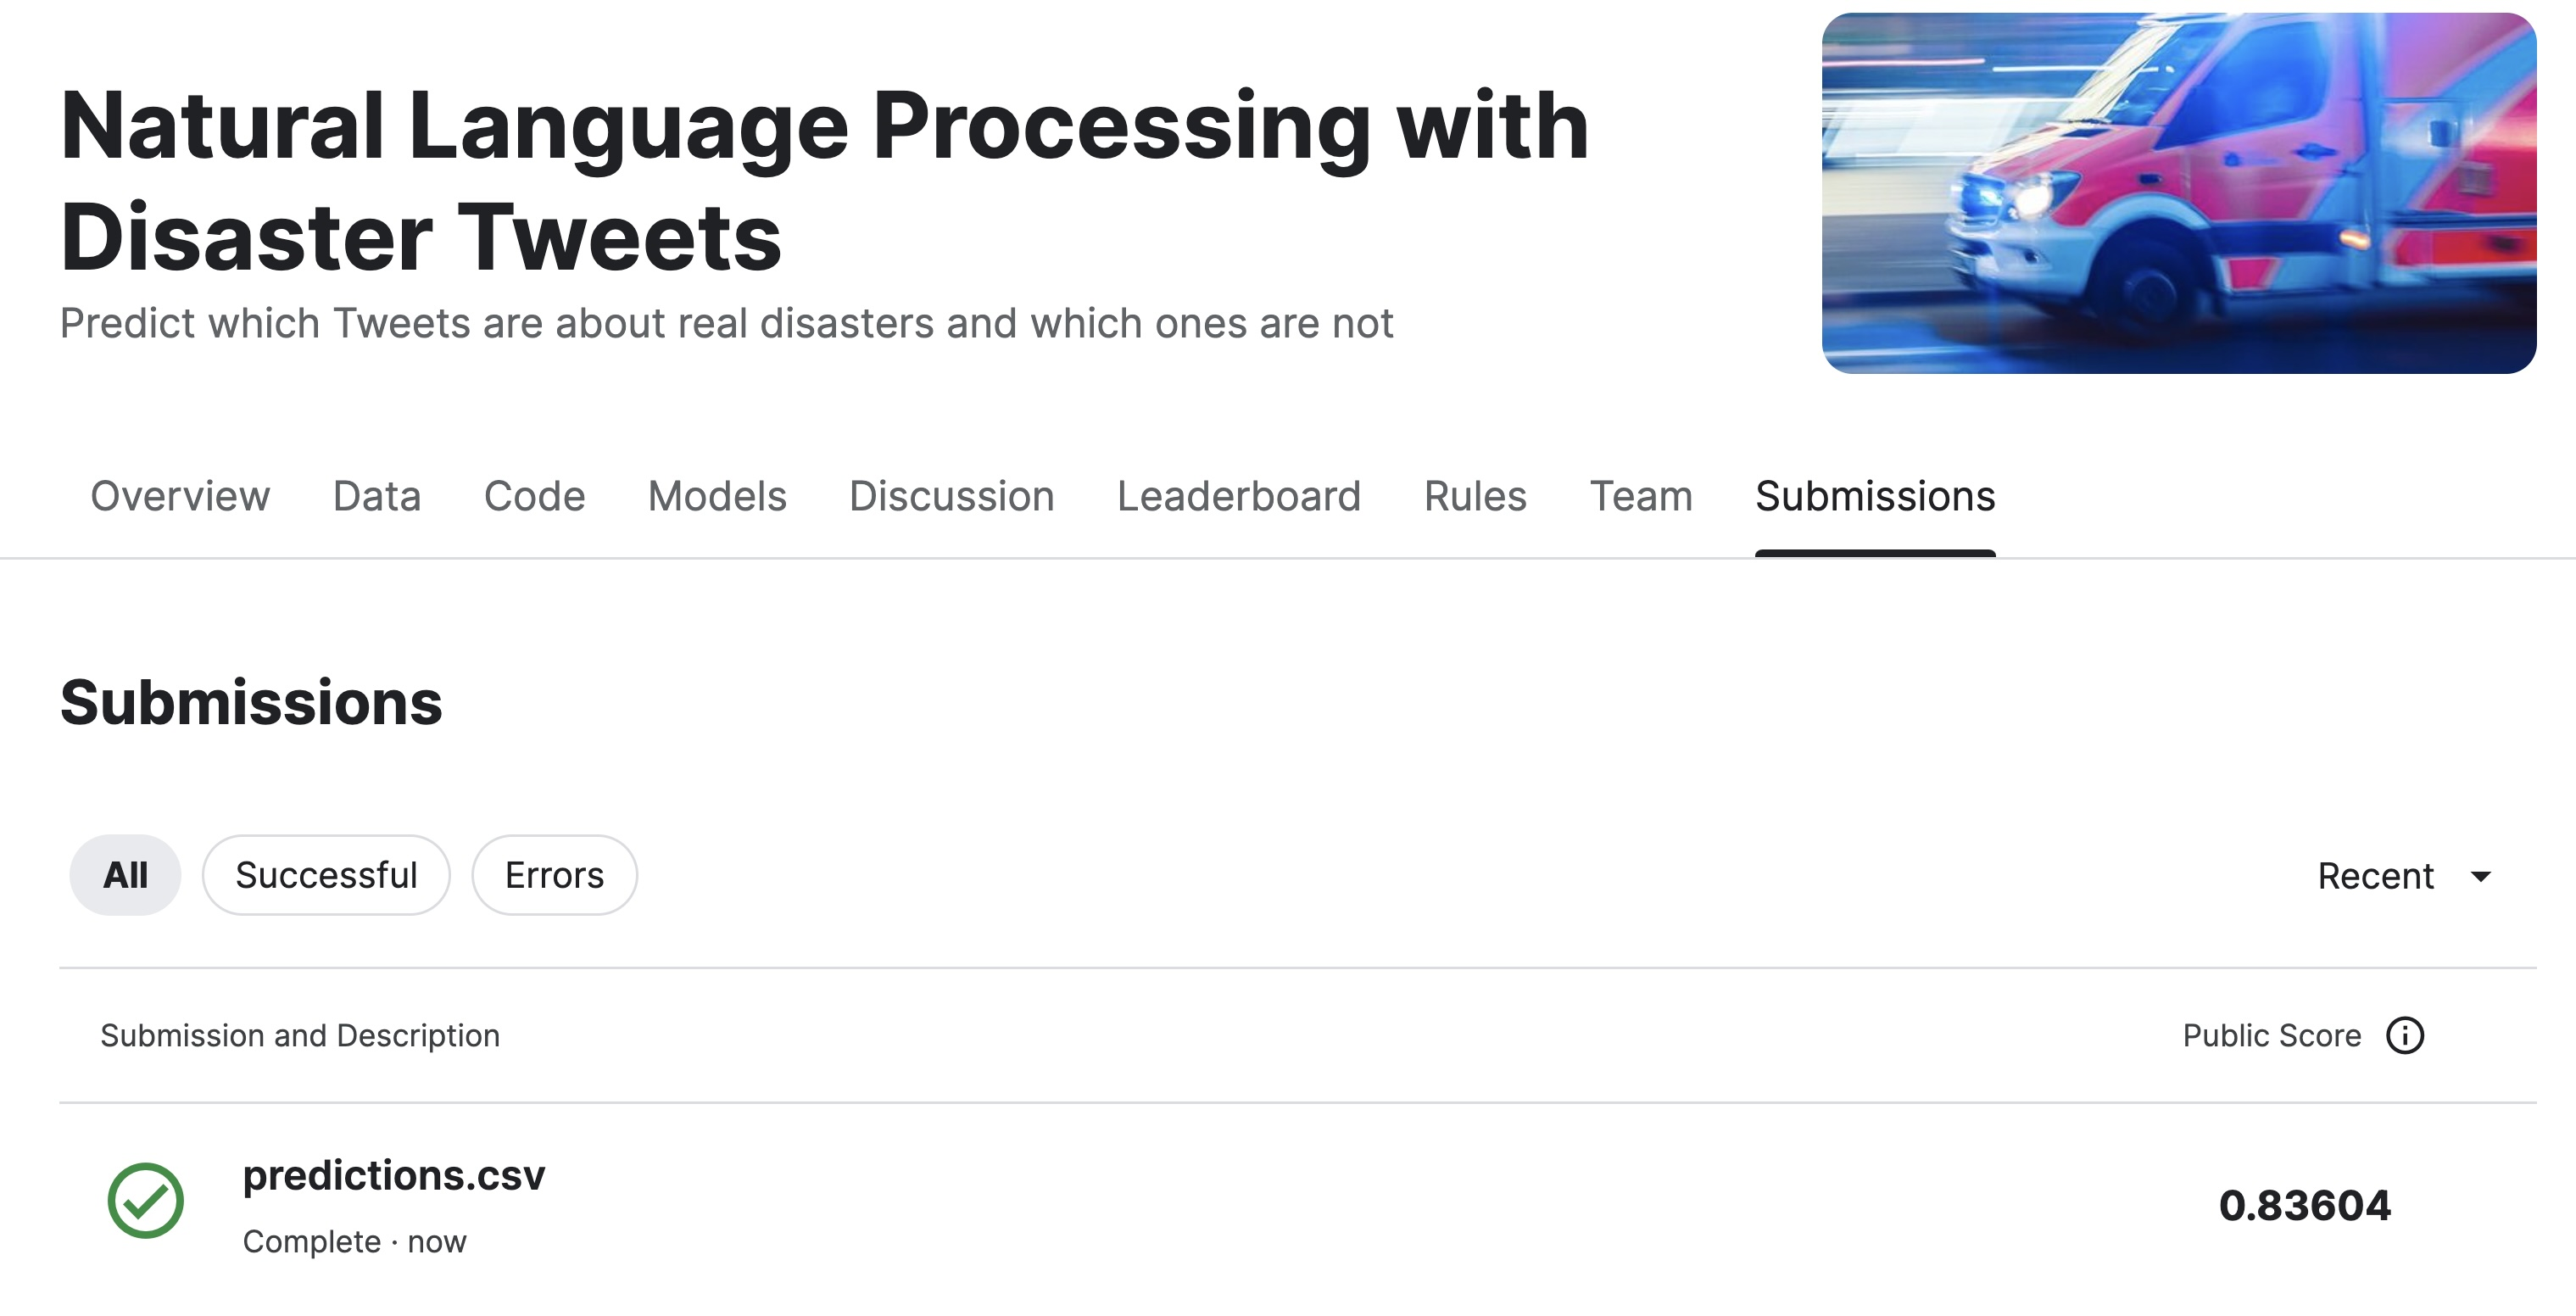

In [26]:
from IPython.display import Image
image_path = 'Kaggle_Score.jpg'
Image(filename = image_path)